In [85]:
from nilearn.image import resample_img, resample_to_img
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt


In [82]:
cortical_atlas_path = "/Users/yibeichen/Desktop/fusi/atlas/atlas_MBM_cortex_vH.nii.gz"
subcortical_atlas_path = "/Users/yibeichen/Desktop/fusi/atlas/SAMv1.0.nii.gz"
subcortical_template_path = "/Users/yibeichen/Desktop/fusi/atlas/SAM_T2_template.nii.gz"

cortical_atlas_img = nib.load(cortical_atlas_path)
subcortical_atlas_img = nib.load(subcortical_atlas_path)
subcortical_template_img = nib.load(subcortical_template_path)

In [84]:
target_voxel_size = (0.2, 0.2, 0.2)
original_affine = subcortical_template_img.affine
target_affine = original_affine.copy()

# Update the affine to reflect the new voxel sizes
target_affine[:3, :3] = np.diag(target_voxel_size)

# Resample the subcortical image to the new voxel size, allowing the shape to change
resampled_subcortical_img = resample_img(subcortical_template_img, target_affine=target_affine, interpolation='nearest')

# Align origins by setting the translation part of the affine to match the cortical atlas
aligned_affine = resampled_subcortical_img.affine
aligned_affine[:3, 3] = cortical_atlas_img.affine[:3, 3]  # Match the origins

# Create a new image with the aligned affine
aligned_subcortical_img = nib.Nifti1Image(resampled_subcortical_img.get_fdata(), aligned_affine)

# Save the aligned and resampled subcortical atlas
aligned_subcortical_img.to_filename('/Users/yibeichen/Desktop/fusi/atlas/SAM_T2_template_200um.nii.gz')



In [86]:
aligned_subcortical_img = resample_to_img(subcortical_template_img, cortical_atlas_img, interpolation='nearest')

# Save the resampled subcortical atlas
aligned_subcortical_img.to_filename('/Users/yibeichen/Desktop/fusi/atlas/SAM_T2_template_200um_same_shape.nii.gz')

(147, 200, 135)


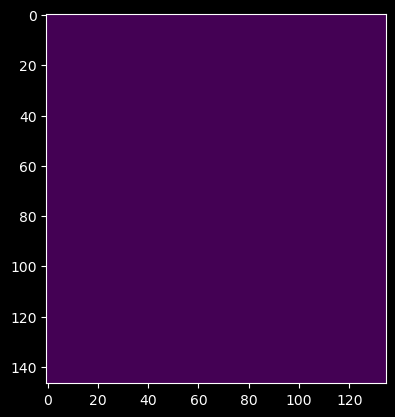

In [74]:
from nibabel.processing import resample_from_to
resample_img2 = resample_from_to(ct_img, mri_img)
print(resample_img2.shape)
plt.imshow(resample_img2.get_fdata()[:, 50, :])
plt.show()

In [14]:
# Load both images
ct_img = nib.load(ct_path)
mri_img = nib.load(mri_path)

# Print original information
print("CT shape:", ct_img.shape, "CT zooms:", ct_img.header.get_zooms()[:3])
print("MRI shape:", mri_img.shape, "MRI zooms:", mri_img.header.get_zooms()[:3])

#

CT shape: (133, 113, 189) CT zooms: (1.0, 1.0, 1.0)
MRI shape: (147, 200, 135) MRI zooms: (0.2, 0.2, 0.2)


In [17]:
# Print original information
print("CT original shape:", ct_img.shape)
print("CT original zooms:", ct_img.header.get_zooms()[:3])

# Create new affine matrix
target_zooms = (0.2, 0.2, 0.2)
original_zooms = ct_img.header.get_zooms()[:3]

# Create new affine by properly scaling the original
new_affine = ct_img.affine.copy()
scaling_factors = [t/o for t, o in zip(target_zooms, original_zooms)]

# Apply scaling to the rotation/scaling part of the affine matrix
for i in range(3):
    new_affine[:3, i] *= scaling_factors[i]

# Resample image with new affine but keep original shape
resampled_ct = resample_img(
    ct_img,
    target_affine=new_affine,
    target_shape=ct_img.shape
)

print("Resampled CT shape:", resampled_ct.shape)
print("Resampled CT zooms:", resampled_ct.header.get_zooms()[:3])

CT original shape: (133, 113, 189)
CT original zooms: (1.0, 1.0, 1.0)
Resampled CT shape: (133, 113, 189)
Resampled CT zooms: (0.2, 0.2, 0.2)


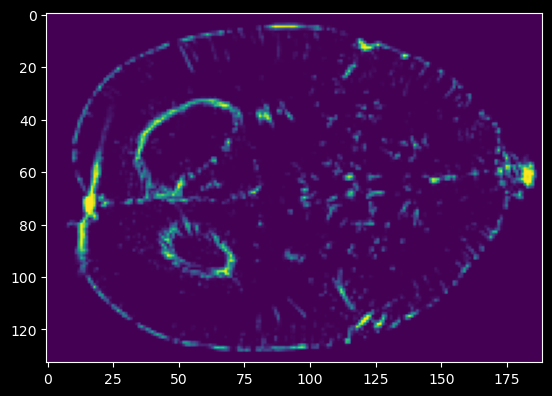

In [23]:
# plot the resampled image
plt.imshow(ct_img.get_fdata()[:, 50, :])
plt.show()


In [13]:
# Print original image information
print("Original image shape:", ct_img.shape)
print("Original zooms (voxel size):", ct_img.header.get_zooms()[:3])

# Define new target voxel size
target_voxel_size = (0.2, 0.2, 0.2)  # in mm

# Calculate scaling factors - we want to make voxels smaller, so divide target by original
scaling_factors = tuple(o/t for o, t in zip(ct_img.header.get_zooms()[:3], target_voxel_size))
print("Scaling factors:", scaling_factors)  # Should be (5.0, 5.0, 5.0)

# Define the new affine with the target voxel size
new_affine = ct_img.affine.copy()
new_affine[:3, :3] /= scaling_factors

# Resample the image
resampled_img = resample_img(ct_img, target_affine=new_affine)
print("Resampled image shape:", resampled_img.shape)

Original image shape: (133, 113, 189)
Original zooms (voxel size): (1.0, 1.0, 1.0)
Scaling factors: (5.0, 5.0, 5.0)
Resampled image shape: (661, 561, 941)


In [21]:
print("Resampled image shape:", resampled_img.shape)

Resampled image shape: (661, 561, 941)


In [42]:
resampled_img.header.get_zooms()[:3]

(0.2, 0.2, 0.2)

In [22]:
# plot the resampled imageimport numpy as np

# Calculate the desired number of voxels in each dimension
target_shape = ct_img.shape

# Calculate the starting and ending indices to crop the center of the resampled image
current_shape = resampled_img.shape
crop_slices = tuple(
    slice((current_dim - target_dim) // 2, (current_dim + target_dim) // 2)
    for current_dim, target_dim in zip(current_shape, target_shape)
)

# Apply the crop
cropped_data = resampled_img.get_fdata()[crop_slices]
cropped_affine = resampled_img.affine.copy()

# Adjust the affine to reflect the new FOV center
for i, crop in enumerate(crop_slices):
    cropped_affine[i, 3] += crop.start * target_voxel_size[i]

# Save the cropped image as a new Nifti1Image
cropped_img = nib.Nifti1Image(cropped_data, cropped_affine)
print("Cropped image shape:", cropped_img.shape)



Cropped image shape: (133, 113, 189)


In [25]:
# save the cropped image
nib.save(cropped_img, output_path)

# plot the cropped image

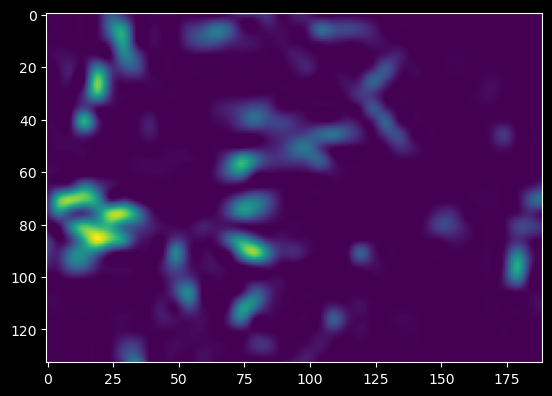

In [24]:
plt.imshow(cropped_img.get_fdata()[:, 50, :])
plt.show()


In [32]:
from nilearn.image import resample_to_img

resampled_ct_img = resample_to_img(
    resampled_img, mri_img, force_resample=True
)

In [38]:
resampled_ct_img.shape

(147, 200, 135)

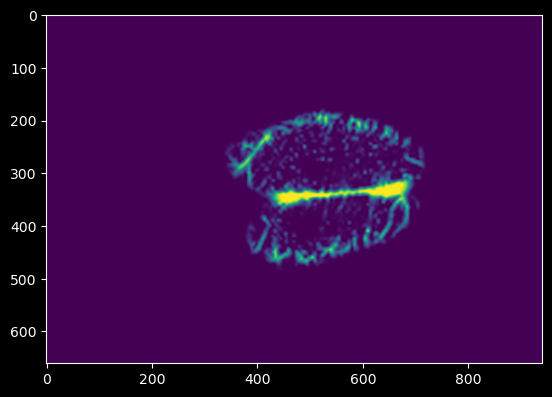

In [51]:
plt.imshow(resampled_img.get_fdata()[:, 70, :])
plt.show()


In [56]:
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom

ct_data = ct_img.get_fdata()
original_affine = ct_img.affine
original_shape = ct_data.shape
original_spacing = ct_img.header.get_zooms()[:3]

# Define target parameters
target_spacing = (0.2, 0.2, 0.2)  # Desired voxel size
target_shape = (163, 212, 232)  # Desired final shape

# Calculate the zoom factor based on both shape and spacing
zoom_factors = [
    (original_spacing[i] * original_shape[i]) / (target_spacing[i] * target_shape[i]) for i in range(3)
]

print(zoom_factors)
# Apply zoom to achieve the exact target shape
resampled_data = zoom(ct_data, zoom=zoom_factors, order=3)  # order=3 for cubic interpolation

# Verify the shape matches target_shape exactly (or close due to rounding)
resampled_data = np.round(resampled_data).astype(ct_data.dtype)  # Ensures the data type consistency

# Adjust affine to reflect new spacing
new_affine = original_affine.copy()
for i in range(3):
    new_affine[i, i] = target_spacing[i]

# Create a new NIfTI image with the resampled data and updated affine
resampled_img2 = nib.Nifti1Image(resampled_data, new_affine)

# Save the result
# resampled_img.to_filename('resampled_resized_ct_image.nii')


[4.079754601226994, 2.665094339622641, 4.073275862068965]


In [57]:
resampled_img2.shape

(543, 301, 770)

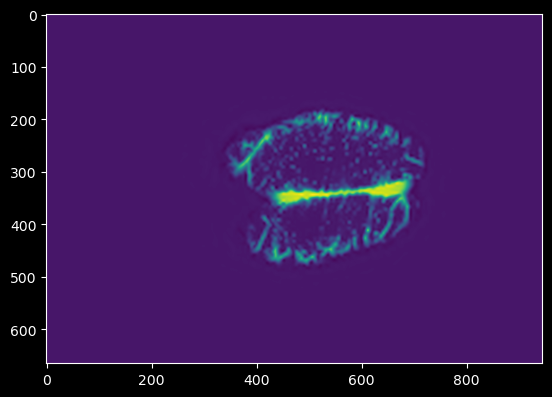

In [53]:
plt.imshow(resampled_img2.get_fdata()[:, 70, :])
plt.show()


In [76]:
template_file1 = "/Users/yibeichen/Desktop/fusi/atlas/template_T2w_brain.nii.gz"
template_file2 = "/Users/yibeichen/Desktop/fusi/atlas/SAM_T2_template.nii.gz"

In [77]:
import  nibabel as nb
ct = nb.load('/Users/yibeichen/Desktop/fusi/microCT/wolfgang/CT.nii.gz')
new_aff = nb.affines.rescale_affine(ct.affine, ct.shape, (0.2, 0.2, 0.2))
resized = nb.Nifti1Image(ct.dataobj, new_aff, ct.header)
resized.to_filename('/Users/yibeichen/Desktop/fusi/microCT/wolfgang/CT_resized.nii.gz')